# ORIE 4580/5580/5581 Assignment 4

#### Students: Xiaotong Tan (xt254) and Raymond Tao (st2242)

### Github link: [HW4](https://github.com/raymondtaj/orie5580/blob/main/HW4/HW4.ipynb)


### Instructions


* Due Thursday October 2, at 11.59pm on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/80773#:~:text=Assignments-,Assignments,-Assignments%20module%20publish).
* Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Gemini/Claude/ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**.
* You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.




### Suggested reading

Chapters 5 (sections 5.1, 5.2 and 5.3) and 6, as well as chapter 11 (to revise again what we discussed in class about confidence intervals) of [Simulation by Ross](https://catalog.library.cornell.edu/catalog/12745977).

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<hr><hr>

# Question 1: The Inspection paradox (30 pts)

Have you ever felt like you wait too long for elevators, taxis, buses, etc.? Guess what - you may be right!

We are going to simulate a number of train and passenger arrivals at a station, and try to measure the time each passenger needs to wait for a train. To do this, first generate a stream of 10,000 train passengers, each of whom have an independent arrival time which is uniformly distributed over an interval of 1,000 minutes (i.e., passenger $i$ arrives at time $T_i\sim [0,1000]$. Sort the passengers by arrival time, and use this resulting vector for all subsequent parts.

<hr>

**(a)** Suppose trains arrive at the station deterministically every 10 minutes. Assume each train has infinite capacity, so that everyone waiting at the station when a train arrives can get on; also assume that passengers get on the train instantaneously. Estimate the expected time (with CIs) that any *randomly chosen* passenger spends waiting at the station for the next train.

<hr>

## Ans.

In [16]:
def mean_ci(x, alpha=0.05):
    x = np.asarray(x, dtype=float)
    m = x.mean()
    se = x.std(ddof=1) / np.sqrt(len(x))
    z = 1.96
    return m, m - z * se, m + z * se

def next_wait_times(arrivals, train_times):
    """Wait time until the NEXT train for each arrival."""
    idx = np.searchsorted(train_times, arrivals, side="left")
    return train_times[idx] - arrivals

# Passengers
rng = np.random.default_rng(42)
T = 1000.0
n_passengers = 10_000
passengers = np.sort(rng.uniform(0.0, T, size=n_passengers))

# Deterministic train schedule
period = 10.0
det_trains = np.arange(-5 * period, T + 5 * period + period, period)

wait_det = next_wait_times(passengers, det_trains)
det_wait_mean, det_wait_lo, det_wait_hi = mean_ci(wait_det)

print("Mean wait:", det_wait_mean, "CI:", (det_wait_lo, det_wait_hi))

Mean wait: 4.976402430665842 CI: (4.9199507878173865, 5.032854073514297)


<hr>

**(b)** Next, assume trains arrive at the station with *inter-arrival* time (i.e., time between two trains) distributed according to an exponential distribution with mean 10 minutes. Again, use your vector of passenger arrival times to estimate the expected waiting time for a randomly chosen passenger.

<hr>

## Ans.

In [17]:
def simulate_exponential_trains(mean=10.0, T=1000.0, seed=0):
    rng = np.random.default_rng(seed)
    t = -2000.0
    trains = []
    while t < T + 2000.0:
        t += rng.exponential(mean)
        trains.append(t)
    return np.array(trains)

R = 400
exp_mean = 10.0
rep_wait_means = []

for r in range(R):
    trains = simulate_exponential_trains(exp_mean, T, 1000 + r)
    w = next_wait_times(passengers, trains)
    rep_wait_means.append(w.mean())

w_m, w_lo, w_hi = mean_ci(np.array(rep_wait_means))

print("Mean wait:", w_m, "CI:", (w_lo, w_hi))

Mean wait: 9.94098667980577 CI: (9.806611030692391, 10.075362328919148)


<hr>

**(c)** (Hopefully, you found the answer in part (b) to be different, and surprisingly so, compared to part (a).)

The train service claims that there is a train every $10$ minutes on average. In part (a), this is clearly the case, but is it so in part (b) as well? To understand this, use your data from part (b) to compute an empirical estimate with CIs for the inter-arrival times between trains.

<hr>

In [18]:
rep_inter_means = []
rep_inter_counts = []

for r in range(R):
    trains = simulate_exponential_trains(exp_mean, T, 2000 + r)
    in_window = trains[(trains >= 0.0) & (trains <= T)]
    inter = np.diff(in_window)
    if len(inter) > 0:
        rep_inter_means.append(inter.mean())
        rep_inter_counts.append(len(inter))

IA_m, IA_lo, IA_hi = mean_ci(np.array(rep_inter_means))

print("Mean inter-arrival:", IA_m, "CI:", (IA_lo, IA_hi))

Mean inter-arrival: 9.973206212626708 CI: (9.883398899192347, 10.06301352606107)


<hr>

**(d)** To understand what may be happening between parts (a) and (b), use the data from the simulations in parts (a) and (b) to estimate the average inter-arrival time between trains that each passenger experiences in each case. In other words, if passenger $i$ gets on train number $n$, thn we want to define his inter-arrival time $I_i$ to be the difference $A_n~-~A_{n-1}$ where $A_n$ is the arrival time of train $n$.

Compute the sample mean and CI of the interval $I_i$ for a randomly chosen passenger $i$ in each of the two settings. How are these related to the waiting time estimates you got in each part? Can you explain this?

<hr>

## Ans.

In [19]:
def headway_seen_by_passengers(arrivals, train_times):
    idx = np.searchsorted(train_times, arrivals, side="left")
    return train_times[idx] - train_times[idx - 1]

rep_head_means = []

for r in range(R):
    trains = simulate_exponential_trains(exp_mean, T, 3000 + r)
    H = headway_seen_by_passengers(passengers, trains)
    rep_head_means.append(H.mean())

H_m, H_lo, H_hi = mean_ci(np.array(rep_head_means))

print("Mean passenger headway:", H_m, "CI:", (H_lo, H_hi))

Mean passenger headway: 20.078779838747266 CI: (19.803673255625448, 20.353886421869085)


A randomly chosen gap has mean 10 minutes in both settings, but a randomly chosen passenger lands in gaps with probability proportional to their length. In the exponential case, that length-bias doubles the average gap a passenger sees (~20 min), so their wait doubles relative to the deterministic case (~10 vs ~5 min). 

In mathmatical language, if the interval length is $X$, and passengers arrive uniformly at random in time, then
$$
\mathbb{E}[W] = \frac{\mathbb{E}[X^2]}{2 \, \mathbb{E}[X]}.
$$
This formula shows why variability (large $\mathbb{E}[X^2]$) makes waiting times longer than the train arrival average.

**(e) (Optional for all students)** Based on your previous parts, can you come up with an explanation for what is going on?  

<hr><hr>

# Question 2: Generating random samples in some given set (20 pts)

<hr>

**(a)** We want to sample points which are uniformly distributed in the set  $\mathcal{S} = \{(x,y)| x\in \mathbb{R}, y \in [0,e^{-x^2/2}]\}$ (i.e., between the lines $y=0$ and $y=e^{-x^2/2}$). Generate 1000 independent samples $(X_i,Y_i)$, and plot them using a scatterplot, along with the lines $y=0$ and $y=e^{-x^2/2}$.

(Hint: Try to 'reverse' what we do in Acceptance-Rejection).

<hr>

## Ans.

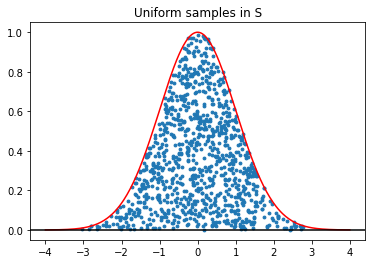

In [20]:

n = 1000
X = np.random.normal(0, 1, size=n)
U = np.random.rand(n)
Y = U * np.exp(-(X**2) / 2)

xs = np.linspace(-4, 4, 400)
curve = np.exp(-xs**2 / 2)
plt.scatter(X, Y, s=8)
plt.plot(xs, curve, 'r')
plt.axhline(0, color='k')
plt.title("Uniform samples in S")
plt.show()

<hr>

**(b)** Next, suppose we want to sample points which are uniformly distributed on the set $\{(x,y)\in\mathbb{R}^2|x^2+y^2 = 1\}$ (i.e., on the *circumference* of the unit circle). One way to do so may be to generate points $(U_i,V_i)$ uniformly in $[-1,1]^2$ (like in the first homework), and then *project* them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{U_i}{\sqrt{U_i^2+V_i^2}},\frac{V_i}{\sqrt{U_i^2+V_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Try checking the histogram of their angles (i.e., the histogram of $\theta_i = \tan^{-1}(Y_i/X_i)$).

<hr>

## Ans.

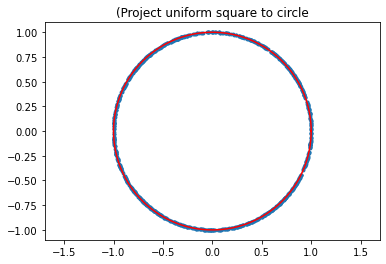

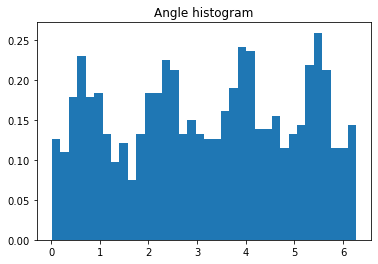

In [21]:
U1 = np.random.uniform(-1, 1, size=n)
V1 = np.random.uniform(-1, 1, size=n)
r1 = np.sqrt(U1**2 + V1**2)
r1[r1 == 0] = 1.0
Xb = U1 / r1
Yb = V1 / r1
theta_b = np.mod(np.arctan2(Yb, Xb), 2*np.pi)


ang = np.linspace(0, 2*np.pi, 400)
plt.scatter(Xb, Yb, s=8)
plt.plot(np.cos(ang), np.sin(ang), 'r')
plt.axis("equal")
plt.title("(Project uniform square to circle")
plt.show()


plt.hist(theta_b, bins=36, density=True)
plt.title("Angle histogram")
plt.show()

These points are not uniformly distributed on the circumference of the circle as the angle histogram shows peaks near the diagonals.

<hr>

**(c)** Next, generate points $(Z_i,W_i)$ as independent standard normals (i.e., $(Z_i,W_i)\sim \mathcal{N}(0,I_2)$), and again project them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{Z_i}{\sqrt{Z_i^2+W_i^2}},\frac{W_i}{\sqrt{Z_i^2+W_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Again, check the histogram of their angles $\theta_i$. Can you explain the difference between parts (b) and (c)?

<hr>

## Ans.

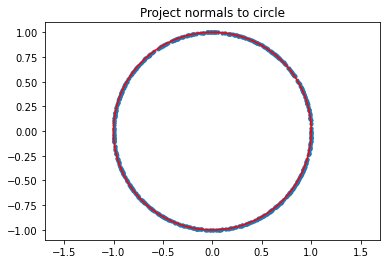

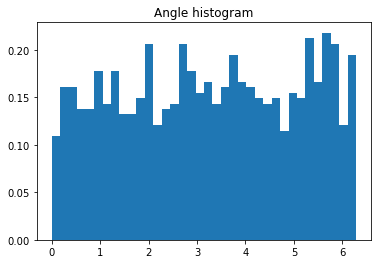

In [22]:
Z = np.random.normal(0, 1, size=n)
W = np.random.normal(0, 1, size=n)
r2 = np.sqrt(Z**2 + W**2)
Xc = Z / r2
Yc = W / r2
theta_c = np.mod(np.arctan2(Yc, Xc), 2*np.pi)

plt.scatter(Xc, Yc, s=8)
plt.plot(np.cos(ang), np.sin(ang), 'r')
plt.axis("equal")
plt.title("Project normals to circle")
plt.show()

# angle histogram
plt.hist(theta_c, bins=36, density=True)
plt.title("Angle histogram")
plt.show()

These points are approximatly uniformly distributed on the circumference of the circle as the angle histogram angle histogram is nearly flat.

<hr><hr>

# Question 3: Multivariate normals, and some finance (20 points)


Assume the following means and covariance matrix for the net annual returns (annual returns after accounting for inflation) on three investments:

$$\boldsymbol{\mu}=
\begin{bmatrix}
    \mu_{\text{U.S. stocks}}\\
    \mu_{\text{U.S. bonds}}\\
    \mu_{\text{EM bonds}}
\end{bmatrix}=
\begin{bmatrix}
    0.14 \\
    0.07 \\
    0.16\\
\end{bmatrix},$$

Moreover, we have $\sigma^2_{\text{U.S. stocks}}=0.0625, \sigma^2_{\text{U.S. bonds}}=0.01$ and $\sigma^2_{\text{EM bonds}}=0.09$. Assuming all three instruments are independent of each other, what is the probability that all three financial products simultaneously yield a positive return?


<hr>

## Ans.

 
The returns are normally distributed with the following means and variances:

$$
\mu =
\begin{bmatrix}
0.14\\ 0.07\\ 0.16
\end{bmatrix}, 
\qquad
\sigma^2 =
\begin{bmatrix}
0.0625\\ 0.01\\ 0.09
\end{bmatrix}.
$$


For a normally distributed random variable $X \sim \mathcal{N}(\mu,\sigma^2)$,  
the probability of being positive is given by:

$$
\Pr(X > 0) = \Phi\!\left(\frac{\mu}{\sigma}\right),
$$

where $\Phi(\cdot)$ is the cumulative distribution function (CDF) of the standard normal.  

Because the three returns are independent, the joint probability that *all three* are positive is simply the product of the individual probabilities:

$$
\Pr(X_1 > 0, X_2 > 0, X_3 > 0) 
= \prod_{i=1}^{3} \Phi\!\left(\frac{\mu_i}{\sigma_i}\right).
$$


Taking square roots of the variances gives the standard deviations:

$$
\sigma_1 = \sqrt{0.0625} = 0.25, \quad
\sigma_2 = \sqrt{0.01} = 0.10, \quad
\sigma_3 = \sqrt{0.09} = 0.30.
$$

These represent the volatility of each instrument’s return.


Next, we standardize each mean relative to its standard deviation:

$$
z_1 = \frac{0.14}{0.25} = 0.56, \quad
z_2 = \frac{0.07}{0.10} = 0.70, \quad
z_3 = \frac{0.16}{0.30} \approx 0.533.
$$

Each z-value indicates how many standard deviations the expected return is above zero.



Using the standard normal CDF:

$$
\Phi(0.56) \approx 0.7123, \quad
\Phi(0.70) \approx 0.7580, \quad
\Phi(0.533) \approx 0.7031.
$$

So, individually, each instrument has around a 71%, 76%, and 70% chance of being positive, respectively.


Finally, multiplying the three together gives:

$$
\Pr(\text{all three positive})
= 0.7123 \times 0.7580 \times 0.7031
\approx 0.380.
$$


<hr>

**(b)** Next, assume that the assets are not independent, but rather, have covariance matrix
$$\boldsymbol{\Sigma}=
\begin{bmatrix}
    0.0625 & -0.01 & 0.0375 \\
    -0.01 & 0.01 & -0.015 \\
    0.0375 & -0.015 & 0.09
\end{bmatrix}.$$

Using simulation, estimate the probability that all three financial products simultaneously yield a positive return.
For the purposes of this problem, you are **not allowed** to use the Python function ${\tt numpy.random.multivariate\_normal}$, but rather, should generate *independent* normal rvs, and then apply the method(s) discussed in class.
In particular, you can compute the Cholesky decomposition of the covariance matrix using the Python function ${\tt scipy.linalg.cholesky(sigma, lower=True)}$.
<hr>

## Ans.



In [23]:
import numpy as np
from scipy.linalg import cholesky


mu = np.array([0.14, 0.07, 0.16])
Sigma = np.array([
    [0.0625, -0.01,   0.0375],
    [-0.01,   0.01,  -0.015 ],
    [0.0375, -0.015,  0.09  ]
])


L = cholesky(Sigma, lower=True)

# Monte Carlo
rng = np.random.default_rng(42)
N = 500_000  
Z = rng.standard_normal((N, 3))         
X = mu + Z @ L.T                        

p_hat = np.mean((X > 0).all(axis=1))
se = np.sqrt(p_hat * (1 - p_hat) / N)    
(p_hat, se, (p_hat - 1.96*se, p_hat + 1.96*se))

(0.370188, 0.0006828599338898132, (0.368849594529576, 0.37152640547042404))

<hr><hr>

# Question 4: Covariance and copulas (30 points)

In general (i.e., apart from multivariate normals), *there is no closed form formula for generating rvs with given marginals and given covariance matrix*. However, a popular heuristic is the so-called *Gaussian copula trick*, which is widely used in finance. In this question, we will try and get a sense of how we can generate correlated uniforms, and how the Gaussian copula trick works.

<hr>

**(a)** We will first try and make a method for generating two correlated uniform random variables $V_1$, $V_2$ with mean $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0$, variance $Var(V_1)=Var(V_2)=1$, and covariance $Cov( V_1, V_2 ) = \sigma_{12}$ (for some given $\sigma_{12}\geq 0$).

For what $\alpha,\beta\in\mathbb{R}$ does a uniform distribution on $[\alpha,\beta]$ have mean $0$ and variance $1$.

<hr>

## Ans.


For a random variable 
$$
X \sim \mathrm{Unif}[\alpha,\beta],
$$
the mean and variance are given by  

$$
\mathbb{E}[X] = \frac{\alpha + \beta}{2}, 
\qquad 
\mathrm{Var}(X) = \frac{(\beta - \alpha)^2}{12}.
$$


We require the mean to be 0:
$$
\frac{\alpha + \beta}{2} = 0 
\;\;\;\Rightarrow\;\;\; \beta = -\alpha.
$$


We require the variance to be 1:
$$
\frac{(\beta - \alpha)^2}{12} = 1.
$$

Substituting $\beta = -\alpha$:
$$
\frac{((- \alpha) - \alpha)^2}{12} = 1,
$$
$$
\frac{(-2\alpha)^2}{12} = 1,
$$
$$
\frac{4\alpha^2}{12} = 1,
$$
$$
\alpha^2 = 3.
$$

Solve for $\alpha,\beta$
Thus
$$
\alpha = -\sqrt{3}, 
\qquad 
\beta = \sqrt{3}.
$$


$$
X \sim \mathrm{Unif}[-\sqrt{3}, \, \sqrt{3}]
$$

which has mean 0 and variance 1.


<hr>

**(b)** Next, generate rvs $X_1,X_2\sim Uniform[\alpha, \beta]$ i.i.d (with $\alpha,\beta$ from previous part), and also sample $B\sim Bernoulli(p)$. Define:
\begin{align*}
	V_1 = X_1 \qquad,\qquad
	V_2 = (1-B)X_1+BX_2 = \begin{cases} X_1 & \text{ if $B = 0$} \\ X_2 & \text{ if $B = 1$} \end{cases}
	\end{align*}

What is $\mathbb{E}[V_2]$ and $Var(V_2)$?

<hr>

## Ans.


Let 
$$
X_1, X_2 \stackrel{\text{iid}}{\sim} \mathrm{Unif}[-\sqrt{3},\,\sqrt{3}], \qquad
\mathbb{E}[X_i]=0,\ \mathrm{Var}(X_i)=1,
$$
and let $B\sim\mathrm{Bernoulli}(p)$, independent of $X_1,X_2$.  
Define
$$
V_1 = X_1, \qquad 
V_2 = (1-B)X_1 + B X_2 =
\begin{cases}
X_1, & B=0 \\
X_2, & B=1
\end{cases}.
$$

Expectation:
Using independence and linearity,
$$
\mathbb{E}[V_2] 
= \mathbb{E}\!\left[(1-B)X_1 + B X_2\right]
= \mathbb{E}[1-B]\ \mathbb{E}[X_1] + \mathbb{E}[B]\ \mathbb{E}[X_2]
= (1-p)\cdot 0 + p\cdot 0 = 0.
$$

Variance:
Since $B\in\{0,1\}$ with $B(1-B)=0$, $ (1-B)^2=1-B$, $B^2=B$,
$$
V_2^2 = \big((1-B)X_1 + B X_2\big)^2 = (1-B)X_1^2 + B X_2^2.
$$
Hence
$$
\mathbb{E}[V_2^2]
= \mathbb{E}[1-B]\ \mathbb{E}[X_1^2] + \mathbb{E}[B]\ \mathbb{E}[X_2^2]
= (1-p)\cdot 1 + p\cdot 1 = 1,
$$
and with $\mathbb{E}[V_2]=0$,
$$
\mathrm{Var}(V_2) = \mathbb{E}[V_2^2] - \mathbb{E}[V_2]^2 = 1 - 0 = 1.
$$

Thus:
$$
\boxed{\ \mathbb{E}[V_2]=0,\qquad \mathrm{Var}(V_2)=1\ }
$$
(independent of p).


<hr>

**(c)** For what value of $p$ do we get $Cov(V_1, V_2 )=\sigma_{12}$ (for $\sigma_{12}\geq 0$)?

<hr>

## Ans.


We have
$$
V_1 = X_1, 
\qquad 
V_2 = (1-B)X_1 + B X_2,
$$

with $X_1,X_2 \stackrel{\text{iid}}{\sim}\mathrm{Unif}[-\sqrt{3},\sqrt{3}]$,  
so that $\mathbb{E}[X_i]=0,\ \mathrm{Var}(X_i)=1$.  
Also, $B \sim \mathrm{Bernoulli}(p)$, independent of $X_1,X_2$.


$$
\mathrm{Cov}(V_1,V_2) = \mathbb{E}[V_1 V_2] - \mathbb{E}[V_1]\mathbb{E}[V_2].
$$

From earlier, $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0$.  
So
$$
\mathrm{Cov}(V_1,V_2) = \mathbb{E}[V_1 V_2].
$$


$$
V_1 V_2 = X_1\big((1-B)X_1 + B X_2\big) 
= (1-B)X_1^2 + B X_1X_2.
$$

Taking expectation:
$$
\mathbb{E}[V_1 V_2] 
= \mathbb{E}[1-B]\ \mathbb{E}[X_1^2] + \mathbb{E}[B]\ \mathbb{E}[X_1 X_2].
$$


- $\mathbb{E}[X_1^2] = \mathrm{Var}(X_1) = 1$.
- $X_1,X_2$ are independent with mean 0 $\Rightarrow\ \mathbb{E}[X_1 X_2]=0$.
- $\mathbb{E}[1-B] = 1-p,\ \mathbb{E}[B] = p$.

So
$$
\mathrm{Cov}(V_1,V_2) = (1-p)\cdot 1 + p \cdot 0 = 1-p.
$$


We want
$$
\mathrm{Cov}(V_1,V_2) = \sigma_{12}.
$$

Thus
$$
1 - p = \sigma_{12}
\quad \Rightarrow \quad
p = 1 - \sigma_{12}.
$$


$$
 p = 1 - \sigma_{12}, \quad \text{valid for } 0 \leq \sigma_{12} \leq 1 \
$$


<hr>

**(d)** Create a function to generate two correlated uniform random variables $V_1$, $V_2$ such that $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0,Var(V_1)=Var(V_2)=1$ and $Cov( U_1, U_2 ) = \sigma_{12}$. Use this to show a scatter plot of $(V_1,V_2)$ for correlation values $\sigma_{12}=0,0.25,0.5,0.75$ and $1$.

<hr>

## Ans.

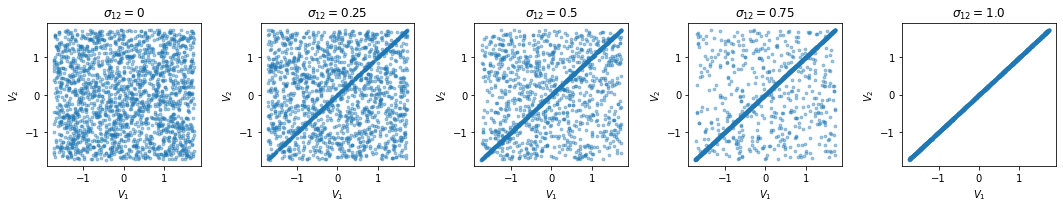

In [24]:
def generate_correlated_uniforms(n, sigma12, rng=None):
    """
    Generate n samples of (V1, V2) with mean 0, var=1, and Cov(V1,V2)=sigma12.
    """
    if rng is None:
        rng = np.random.default_rng()
    X1 = rng.uniform(-np.sqrt(3), np.sqrt(3), size=n)
    X2 = rng.uniform(-np.sqrt(3), np.sqrt(3), size=n)
    
    p = 1 - sigma12
    B = rng.binomial(1, p, size=n)
    
    V1 = X1
    V2 = (1-B) * X1 + B * X2
    
    return V1, V2


rng = np.random.default_rng(42)
sigmas = [0, 0.25, 0.5, 0.75, 1.0]

plt.figure(figsize=(15, 3))
for i, s in enumerate(sigmas, 1):
    V1, V2 = generate_correlated_uniforms(2000, s, rng)
    plt.subplot(1, len(sigmas), i)
    plt.scatter(V1, V2, alpha=0.4, s=8)
    plt.title(f"$\\sigma_{{12}}={s}$")
    plt.xlabel("$V_1$")
    plt.ylabel("$V_2$")
plt.tight_layout()
plt.show()

<hr>

**(e)** Using the above function, compute $\mathbb{P}[V_1\leq 0,V_2\leq 0]$ for the case when $\sigma_{12}=0.5$ (in a financial application, this can correspond to *both* $V_1$ and $V_2$ 'defaulting').

<hr>

## Ans.

In [25]:
rng = np.random.default_rng(42)
V1, V2 = generate_correlated_uniforms(1_000_000, sigma12=0.5, rng=rng)
p_hat = np.mean((V1 <= 0) & (V2 <= 0))
se = np.sqrt(p_hat*(1-p_hat)/len(V1))
p_hat, se, (p_hat-1.96*se, p_hat+1.96*se)

(0.375776, 0.0004843226175020118, (0.37482672766969605, 0.37672527233030395))

<hr>

**(f)** The Gaussian copula trick is based on first generating a multivariate normal vector with given covariance matrix $\Sigma$, and then using inversion to convert it to a vector of uniform rvs, which can then used to generate the desired rvs. We now demonstrate this in the above setting.

Let $\phi(\cdot)$ denote the 1-d normal cdf. Generate $(Z_1,Z_2)$ as multivariate normals with covariance
$\Sigma =\begin{pmatrix}
		1 & 0.5 \\
		0.5 & 1
	\end{pmatrix}$,
and define $W_1 = \alpha + (\beta-\alpha)\phi(Z_1)$ and $W_2 = \alpha + (\beta-\alpha)\phi(Z_2)$.

Argue $W_1$, $W_2$ are uniform on $[\alpha,\beta]$ (and hence $\mathbb{E}[W_1]=\mathbb{E}[W_2]=0,Var(W_1)=Var(W_2)=1$). Next, for $\sigma_{12}=0.5$ and $\alpha,\beta$ as above, write a function to generate $W_1,W_2$ as described, and use these to plot the scatter plot, and compute $\mathbb{P}[W_1\geq 0,W_2\geq 0]$.

<hr>

## Ans.

Let $\Phi(\cdot)$ be the standard normal CDF.  
Generate $(Z_1,Z_2)$ as a bivariate normal with covariance
$$
\Sigma=\begin{pmatrix}1 & 0.5\\[2pt] 0.5 & 1\end{pmatrix}.
$$
Define
$$
W_1=\alpha+(\beta-\alpha)\,\Phi(Z_1),\qquad 
W_2=\alpha+(\beta-\alpha)\,\Phi(Z_2).
$$

---
By the probability integral transform, if $Z\sim\mathcal N(0,1)$ then $U=\Phi(Z)\sim\mathrm{Unif}[0,1]$.  
An affine map preserves uniformity, so for $U\sim\mathrm{Unif}[0,1]$,
$$
\alpha+(\beta-\alpha)U \sim \mathrm{Unif}[\alpha,\beta].
$$
Hence each of $W_1,W_2$ is $\mathrm{Unif}[\alpha,\beta]$, with
$$
\mathbb E[W_i]=0,\qquad \mathrm{Var}(W_i)=1
\quad \text{when } (\alpha,\beta)=(-\sqrt{3},\sqrt{3}).
$$


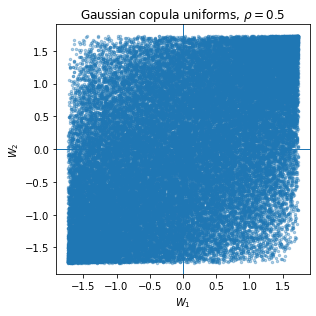

(0.33112, 0.0021046593339540723)

In [26]:
from scipy.stats import norm
from scipy.linalg import cholesky
def gaussian_copula_uniforms(n, rho, alpha=-np.sqrt(3), beta=np.sqrt(3), rng=None):
    """
    Generate n samples from the Gaussian copula with corr=rho, 
    then map margins to Uniform[alpha, beta].
    """
    if rng is None:
        rng = np.random.default_rng()
    Sigma = np.array([[1.0, rho],
                      [rho, 1.0]])
    L = cholesky(Sigma, lower=True)
    Z = rng.standard_normal((n, 2)) @ L.T
    U = norm.cdf(Z)
    W = alpha + (beta - alpha) * U
    return W[:,0], W[:,1]


rho = 0.5                      
alpha, beta = -np.sqrt(3), np.sqrt(3)
rng = np.random.default_rng(42)


n = 50_000
W1, W2 = gaussian_copula_uniforms(n, rho, alpha, beta, rng)

plt.figure(figsize=(4.5,4.5))
plt.scatter(W1, W2, s=6, alpha=0.35)
plt.xlabel("$W_1$")
plt.ylabel("$W_2$")
plt.title("Gaussian copula uniforms, $\\rho=0.5$")
plt.axvline(0, linewidth=1)
plt.axhline(0, linewidth=1)
plt.tight_layout()
plt.show()

# Probability both nonnegative
p_hat = np.mean((W1 >= 0) & (W2 >= 0))
se = np.sqrt(p_hat * (1 - p_hat) / n)
p_hat, se